<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/experiments/Acc_Class_Data_3Classes_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Speech Accent Classifier Project

**Members**: 
Catherine Glossop, Julia Chae, Mingshi Chi, Rocco Ruan 



## Set Up

In [189]:
# package imports 

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display


In [190]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [187]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
  train_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/data_testing/raw_5s_3classes/train', transform=data_transform)
  test_data = [] #test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Librosa_MFCC_Test_Class/test', transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/data_testing/raw_5s_3classes/validation', transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  train_data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy/train', loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy/validation', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()


In [191]:
# train utils 

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.squeeze().float().cuda()
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

## Preparing & Visualizing Dataset

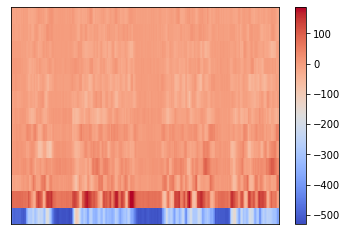

In [192]:
train_data, val_data, []= generate_data_numpy()
visualize_numpy_data(train_data)

In [193]:
from collections import Counter

print(len)
print(dict(Counter(train_data.targets)))
train_data.classes

<built-in function len>
{0: 126, 1: 162, 2: 184}


['english', 'india', 'mandarin']

## Accent Classifier Architecture


## Training 

In [194]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.squeeze().float().cuda()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%25==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
          plot_graphs(iters, losses, [], train_acc, val_acc)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))
    

In [195]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_4'
          self.conv1 = nn.Conv1d(13, 32, 100) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool1d(2, 2) #pool size, stride 
          self.conv2 = nn.Conv1d(32, 64, 100) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*33, 20)
          self.fc2 = nn.Linear(20, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*33)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3601694915254237 Val Accuracy:  0.3670886075949367 Progress:   2.00  % Time Elapsed:   4.11 s 
Epoch 0 Finished.  Time per Epoch:   4.11 s 
Epoch:  1 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:   4.00  % Time Elapsed:   8.25 s 
Epoch 1 Finished.  Time per Epoch:   4.13 s 
Epoch:  2 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:   6.00  % Time Elapsed:  12.25 s 
Epoch 2 Finished.  Time per Epoch:   4.08 s 
Epoch:  3 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:   8.00  % Time Elapsed:  16.27 s 
Epoch 3 Finished.  Time per Epoch:   4.07 s 
Epoch:  4 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  10.00  % Time Elapsed:  20.36 s 
Epoch 4 Finished.  Time per Epoch:   4.07 s 
Epoch:  5 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  12.00  % Time Elapsed:  24.34 s 
Epoch 5 Finished.  T

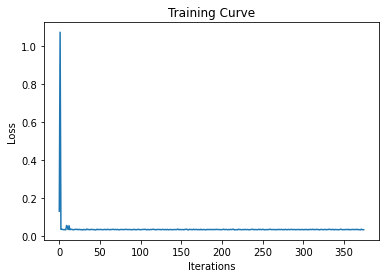

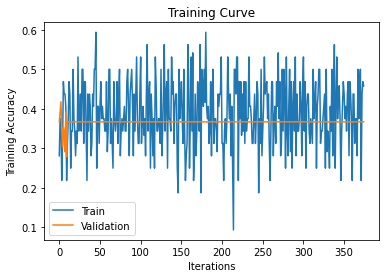

Epoch:  25 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  52.00  % Time Elapsed:  105.41 s 
Epoch 25 Finished.  Time per Epoch:   4.05 s 
Epoch:  26 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  54.00  % Time Elapsed:  109.36 s 
Epoch 26 Finished.  Time per Epoch:   4.05 s 
Epoch:  27 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  56.00  % Time Elapsed:  113.30 s 
Epoch 27 Finished.  Time per Epoch:   4.05 s 
Epoch:  28 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  58.00  % Time Elapsed:  117.24 s 
Epoch 28 Finished.  Time per Epoch:   4.04 s 
Epoch:  29 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  60.00  % Time Elapsed:  121.19 s 
Epoch 29 Finished.  Time per Epoch:   4.04 s 
Epoch:  30 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  62.00  % Time Elapsed:  125.15 s 
Epoch 30 Finis

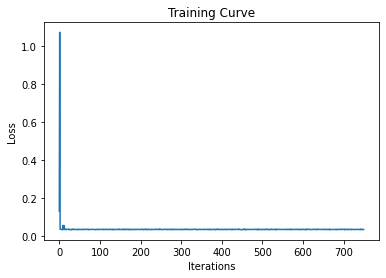

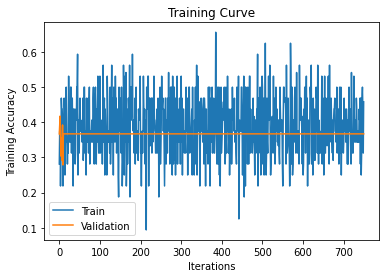

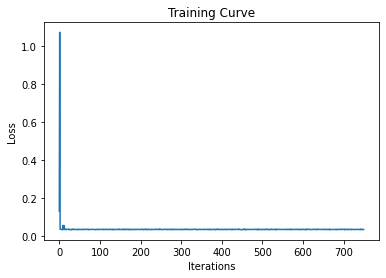

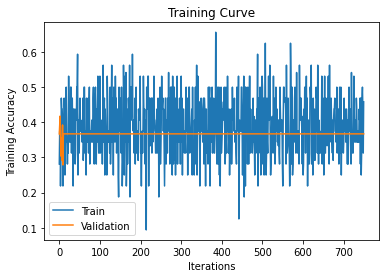

Finished Training
Total time:   199.24 s  Time per Epoch:   3.98 s 


In [196]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 50
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [199]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_4'
          self.conv1 = nn.Conv1d(13, 32, 80) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool1d(2, 2) #pool size, stride 
          self.conv2 = nn.Conv1d(32, 64, 80) #in_channels, out_chanels, kernel_size
          self.conv3 = nn.Conv1d(64, 256, 40)
          self.fc1 = nn.Linear(256*4, 20)
          self.fc2 = nn.Linear(20, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))
          x = x.view(-1, 256*4)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3877118644067797 Val Accuracy:  0.24050632911392406 Progress:   2.00  % Time Elapsed:   3.96 s 
Epoch 0 Finished.  Time per Epoch:   3.96 s 
Epoch:  1 Train Accuracy:  0.3877118644067797 Val Accuracy:  0.3670886075949367 Progress:   4.00  % Time Elapsed:   7.95 s 
Epoch 1 Finished.  Time per Epoch:   3.98 s 
Epoch:  2 Train Accuracy:  0.3940677966101695 Val Accuracy:  0.34177215189873417 Progress:   6.00  % Time Elapsed:  11.86 s 
Epoch 2 Finished.  Time per Epoch:   3.95 s 
Epoch:  3 Train Accuracy:  0.3622881355932203 Val Accuracy:  0.3670886075949367 Progress:   8.00  % Time Elapsed:  15.86 s 
Epoch 3 Finished.  Time per Epoch:   3.96 s 
Epoch:  4 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  10.00  % Time Elapsed:  19.80 s 
Epoch 4 Finished.  Time per Epoch:   3.96 s 
Epoch:  5 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  12.00  % Time Elapsed:  23.75 s 
Epoch 5 Finished. 

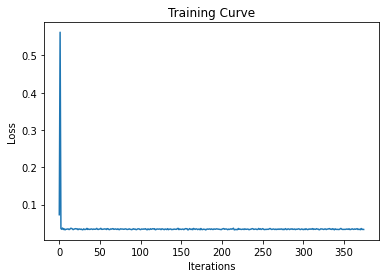

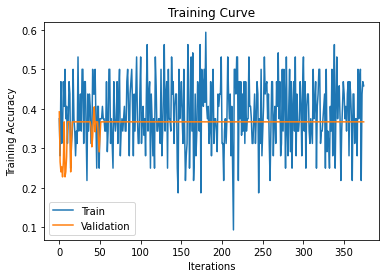

Epoch:  25 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  52.00  % Time Elapsed:  103.24 s 
Epoch 25 Finished.  Time per Epoch:   3.97 s 
Epoch:  26 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  54.00  % Time Elapsed:  107.28 s 
Epoch 26 Finished.  Time per Epoch:   3.97 s 
Epoch:  27 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  56.00  % Time Elapsed:  111.18 s 
Epoch 27 Finished.  Time per Epoch:   3.97 s 
Epoch:  28 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  58.00  % Time Elapsed:  115.10 s 
Epoch 28 Finished.  Time per Epoch:   3.97 s 
Epoch:  29 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  60.00  % Time Elapsed:  119.04 s 
Epoch 29 Finished.  Time per Epoch:   3.97 s 
Epoch:  30 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:  62.00  % Time Elapsed:  123.04 s 
Epoch 30 Finis

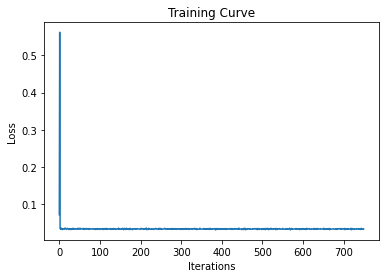

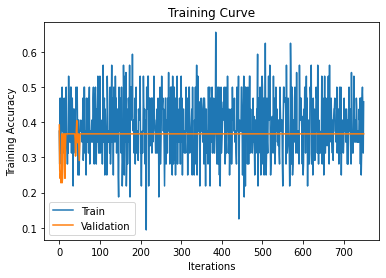

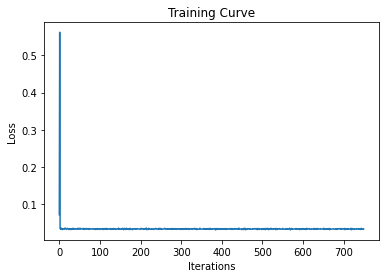

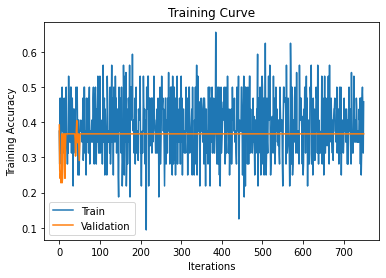

Finished Training
Total time:   198.43 s  Time per Epoch:   3.97 s 


In [200]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 50
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [205]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_4'
          self.conv1 = nn.Conv1d(13, 32, 40) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool1d(2, 2) #pool size, stride 
          self.conv2 = nn.Conv1d(32, 64, 40) #in_channels, out_chanels, kernel_size
          self.conv3 = nn.Conv1d(64, 256, 20)
          self.conv4 = nn.Conv1d(256, 256, 4)
          self.fc1 = nn.Linear(256*13, 20)
          self.fc2 = nn.Linear(20, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))
          x = self.pool(F.relu(self.conv4(x)))
          x = x.view(-1, 256*13)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.4046610169491525 Val Accuracy:  0.3670886075949367 Progress:   1.00  % Time Elapsed:   4.04 s 
Epoch 0 Finished.  Time per Epoch:   4.04 s 
Epoch:  1 Train Accuracy:  0.3983050847457627 Val Accuracy:  0.3670886075949367 Progress:   2.00  % Time Elapsed:   8.02 s 
Epoch 1 Finished.  Time per Epoch:   4.01 s 
Epoch:  2 Train Accuracy:  0.4322033898305085 Val Accuracy:  0.3670886075949367 Progress:   3.00  % Time Elapsed:  12.02 s 
Epoch 2 Finished.  Time per Epoch:   4.01 s 
Epoch:  3 Train Accuracy:  0.4088983050847458 Val Accuracy:  0.379746835443038 Progress:   4.00  % Time Elapsed:  15.97 s 
Epoch 3 Finished.  Time per Epoch:   3.99 s 
Epoch:  4 Train Accuracy:  0.461864406779661 Val Accuracy:  0.4177215189873418 Progress:   5.00  % Time Elapsed:  19.96 s 
Epoch 4 Finished.  Time per Epoch:   3.99 s 
Epoch:  5 Train Accuracy:  0.5444915254237288 Val Accuracy:  0.4430379746835443 Progress:   6.00  % Time Elapsed:  24.01 s 
Epoch 5 Finished.  Tim

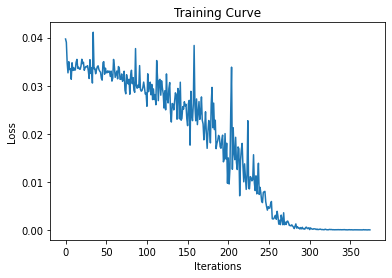

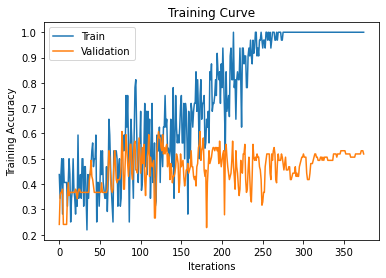

Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.5316455696202531 Progress:  26.00  % Time Elapsed:  105.37 s 
Epoch 25 Finished.  Time per Epoch:   4.05 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  27.00  % Time Elapsed:  109.42 s 
Epoch 26 Finished.  Time per Epoch:   4.05 s 
Epoch:  27 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  28.00  % Time Elapsed:  113.52 s 
Epoch 27 Finished.  Time per Epoch:   4.05 s 
Epoch:  28 Train Accuracy:  1.0 Val Accuracy:  0.5316455696202531 Progress:  29.00  % Time Elapsed:  117.59 s 
Epoch 28 Finished.  Time per Epoch:   4.05 s 
Epoch:  29 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  30.00  % Time Elapsed:  121.69 s 
Epoch 29 Finished.  Time per Epoch:   4.06 s 
Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  31.00  % Time Elapsed:  125.82 s 
Epoch 30 Finished.  Time per Epoch:   4.06 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.506329113

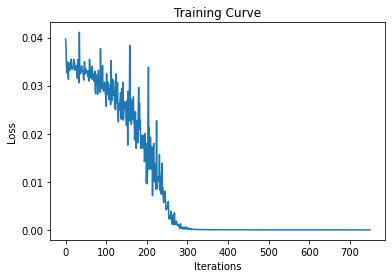

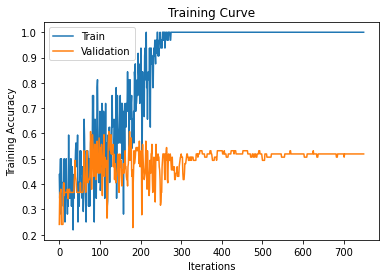

Epoch:  50 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  51.00  % Time Elapsed:  208.95 s 
Epoch 50 Finished.  Time per Epoch:   4.10 s 
Epoch:  51 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  52.00  % Time Elapsed:  213.12 s 
Epoch 51 Finished.  Time per Epoch:   4.10 s 
Epoch:  52 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  53.00  % Time Elapsed:  217.26 s 
Epoch 52 Finished.  Time per Epoch:   4.10 s 
Epoch:  53 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  54.00  % Time Elapsed:  221.35 s 
Epoch 53 Finished.  Time per Epoch:   4.10 s 
Epoch:  54 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  55.00  % Time Elapsed:  225.48 s 
Epoch 54 Finished.  Time per Epoch:   4.10 s 
Epoch:  55 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  56.00  % Time Elapsed:  229.53 s 
Epoch 55 Finished.  Time per Epoch:   4.10 s 
Epoch:  56 Train Accuracy:  1.0 Val Accuracy:  0.518987341

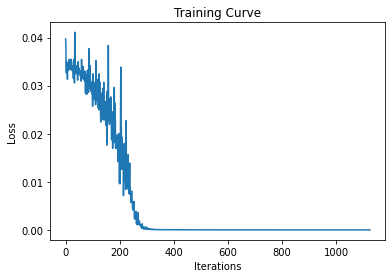

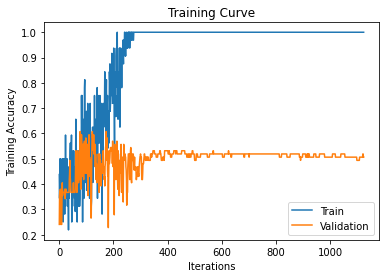

Epoch:  75 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  76.00  % Time Elapsed:  311.97 s 
Epoch 75 Finished.  Time per Epoch:   4.10 s 
Epoch:  76 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  77.00  % Time Elapsed:  316.02 s 
Epoch 76 Finished.  Time per Epoch:   4.10 s 
Epoch:  77 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  78.00  % Time Elapsed:  320.19 s 
Epoch 77 Finished.  Time per Epoch:   4.11 s 
Epoch:  78 Train Accuracy:  1.0 Val Accuracy:  0.4936708860759494 Progress:  79.00  % Time Elapsed:  324.34 s 
Epoch 78 Finished.  Time per Epoch:   4.11 s 
Epoch:  79 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  80.00  % Time Elapsed:  328.45 s 
Epoch 79 Finished.  Time per Epoch:   4.11 s 
Epoch:  80 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  81.00  % Time Elapsed:  332.57 s 
Epoch 80 Finished.  Time per Epoch:   4.11 s 
Epoch:  81 Train Accuracy:  1.0 Val Accuracy:  0.506329113

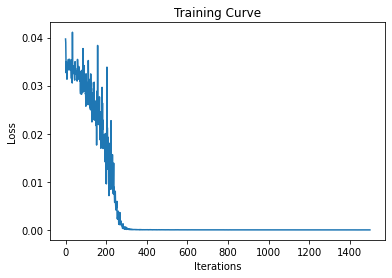

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


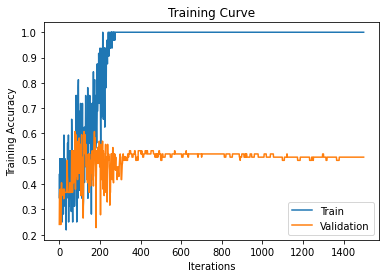

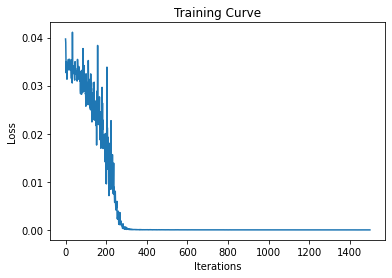

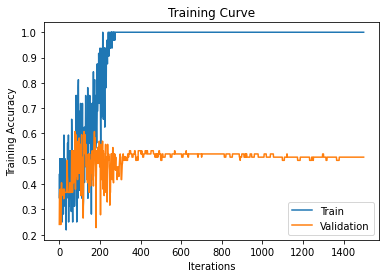

Finished Training
Total time:   410.78 s  Time per Epoch:   4.11 s 


In [206]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 100
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [212]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_4.4'
          self.conv1 = nn.Conv1d(13, 32, 40) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool1d(2, 2) #pool size, stride 
          self.conv2 = nn.Conv1d(32, 64, 20) #in_channels, out_chanels, kernel_size
          self.conv3 = nn.Conv1d(64, 256, 20)
          self.conv4 = nn.Conv1d(256, 256, 4)
          self.fc1 = nn.Linear(256*15, 64)
          self.fc2 = nn.Linear(64, 3)
          self.dropout = nn.Dropout(0.25)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))
          x = self.pool(F.relu(self.conv4(x)))
          x = x.view(-1, 256*15)
          x = self.dropout(x)
          x = F.relu(self.fc1(x))
          x = self.dropout(self.fc2(x))
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3305084745762712 Val Accuracy:  0.3037974683544304 Progress:   1.33  % Time Elapsed:   4.12 s 
Epoch 0 Finished.  Time per Epoch:   4.12 s 
Epoch:  1 Train Accuracy:  0.3961864406779661 Val Accuracy:  0.34177215189873417 Progress:   2.67  % Time Elapsed:   8.21 s 
Epoch 1 Finished.  Time per Epoch:   4.11 s 
Epoch:  2 Train Accuracy:  0.4300847457627119 Val Accuracy:  0.46835443037974683 Progress:   4.00  % Time Elapsed:  12.30 s 
Epoch 2 Finished.  Time per Epoch:   4.10 s 
Epoch:  3 Train Accuracy:  0.3834745762711864 Val Accuracy:  0.3291139240506329 Progress:   5.33  % Time Elapsed:  16.32 s 
Epoch 3 Finished.  Time per Epoch:   4.08 s 
Epoch:  4 Train Accuracy:  0.4110169491525424 Val Accuracy:  0.27848101265822783 Progress:   6.67  % Time Elapsed:  20.40 s 
Epoch 4 Finished.  Time per Epoch:   4.08 s 
Epoch:  5 Train Accuracy:  0.4533898305084746 Val Accuracy:  0.5443037974683544 Progress:   8.00  % Time Elapsed:  24.45 s 
Epoch 5 Finished.

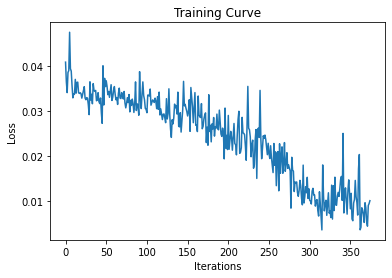

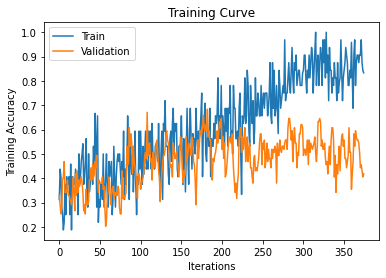

Epoch:  25 Train Accuracy:  0.8813559322033898 Val Accuracy:  0.5443037974683544 Progress:  34.67  % Time Elapsed:  106.19 s 
Epoch 25 Finished.  Time per Epoch:   4.08 s 
Epoch:  26 Train Accuracy:  0.902542372881356 Val Accuracy:  0.5189873417721519 Progress:  36.00  % Time Elapsed:  110.27 s 
Epoch 26 Finished.  Time per Epoch:   4.08 s 
Epoch:  27 Train Accuracy:  0.9194915254237288 Val Accuracy:  0.569620253164557 Progress:  37.33  % Time Elapsed:  114.43 s 
Epoch 27 Finished.  Time per Epoch:   4.09 s 
Epoch:  28 Train Accuracy:  0.9449152542372882 Val Accuracy:  0.5063291139240507 Progress:  38.67  % Time Elapsed:  118.48 s 
Epoch 28 Finished.  Time per Epoch:   4.09 s 
Epoch:  29 Train Accuracy:  0.9110169491525424 Val Accuracy:  0.5822784810126582 Progress:  40.00  % Time Elapsed:  122.56 s 
Epoch 29 Finished.  Time per Epoch:   4.09 s 
Epoch:  30 Train Accuracy:  0.9385593220338984 Val Accuracy:  0.569620253164557 Progress:  41.33  % Time Elapsed:  126.65 s 
Epoch 30 Finished

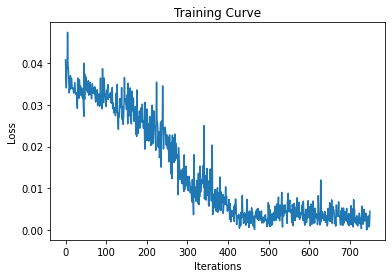

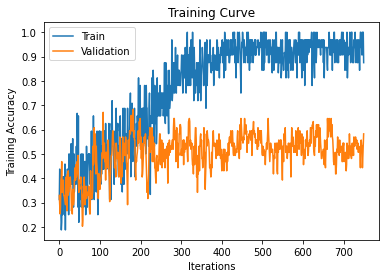

Epoch:  50 Train Accuracy:  0.9194915254237288 Val Accuracy:  0.46835443037974683 Progress:  68.00  % Time Elapsed:  209.95 s 
Epoch 50 Finished.  Time per Epoch:   4.12 s 
Epoch:  51 Train Accuracy:  0.9258474576271186 Val Accuracy:  0.4936708860759494 Progress:  69.33  % Time Elapsed:  213.94 s 
Epoch 51 Finished.  Time per Epoch:   4.11 s 
Epoch:  52 Train Accuracy:  0.940677966101695 Val Accuracy:  0.5569620253164557 Progress:  70.67  % Time Elapsed:  217.85 s 
Epoch 52 Finished.  Time per Epoch:   4.11 s 
Epoch:  53 Train Accuracy:  0.9322033898305084 Val Accuracy:  0.5569620253164557 Progress:  72.00  % Time Elapsed:  221.85 s 
Epoch 53 Finished.  Time per Epoch:   4.11 s 
Epoch:  54 Train Accuracy:  0.9449152542372882 Val Accuracy:  0.5316455696202531 Progress:  73.33  % Time Elapsed:  225.85 s 
Epoch 54 Finished.  Time per Epoch:   4.11 s 
Epoch:  55 Train Accuracy:  0.9300847457627118 Val Accuracy:  0.5822784810126582 Progress:  74.67  % Time Elapsed:  229.82 s 
Epoch 55 Finis

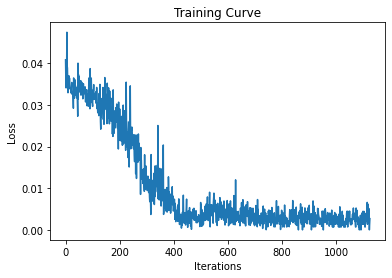

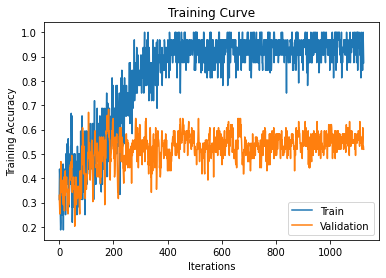

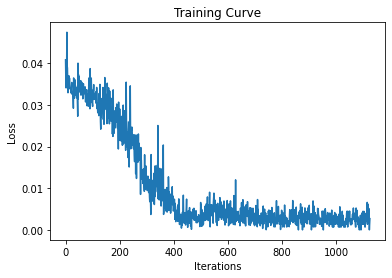

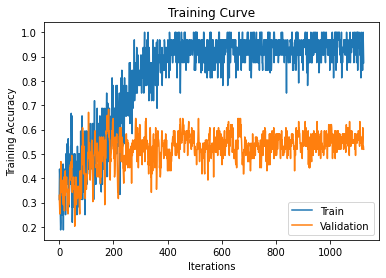

Finished Training
Total time:   305.45 s  Time per Epoch:   4.07 s 


In [213]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 75
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [214]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_4.5'
          self.conv1 = nn.Conv1d(13, 32, 40) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool1d(2, 2) #pool size, stride 
          self.conv2 = nn.Conv1d(32, 64, 20) #in_channels, out_chanels, kernel_size
          self.conv3 = nn.Conv1d(64, 256, 20)
          self.conv4 = nn.Conv1d(256, 256, 4)
          self.fc1 = nn.Linear(256*15, 64)
          self.fc2 = nn.Linear(64, 3)
          self.dropout = nn.Dropout()

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))
          x = self.pool(F.relu(self.conv4(x)))
          x = x.view(-1, 256*15)
          x = self.dropout(x)
          x = F.relu(self.fc1(x))
          x = self.dropout(self.fc2(x))
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3538135593220339 Val Accuracy:  0.35443037974683544 Progress:   1.33  % Time Elapsed:   3.98 s 
Epoch 0 Finished.  Time per Epoch:   3.98 s 
Epoch:  1 Train Accuracy:  0.3347457627118644 Val Accuracy:  0.34177215189873417 Progress:   2.67  % Time Elapsed:   7.91 s 
Epoch 1 Finished.  Time per Epoch:   3.95 s 
Epoch:  2 Train Accuracy:  0.3919491525423729 Val Accuracy:  0.379746835443038 Progress:   4.00  % Time Elapsed:  11.92 s 
Epoch 2 Finished.  Time per Epoch:   3.97 s 
Epoch:  3 Train Accuracy:  0.3580508474576271 Val Accuracy:  0.31645569620253167 Progress:   5.33  % Time Elapsed:  15.92 s 
Epoch 3 Finished.  Time per Epoch:   3.98 s 
Epoch:  4 Train Accuracy:  0.3686440677966102 Val Accuracy:  0.25316455696202533 Progress:   6.67  % Time Elapsed:  19.85 s 
Epoch 4 Finished.  Time per Epoch:   3.97 s 
Epoch:  5 Train Accuracy:  0.3580508474576271 Val Accuracy:  0.26582278481012656 Progress:   8.00  % Time Elapsed:  23.78 s 
Epoch 5 Finished

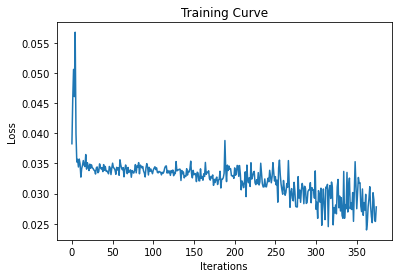

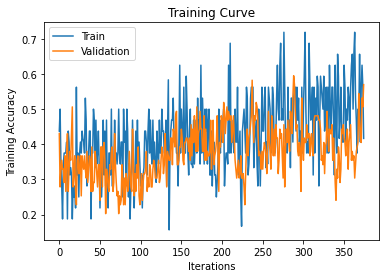

Epoch:  25 Train Accuracy:  0.5254237288135594 Val Accuracy:  0.4050632911392405 Progress:  34.67  % Time Elapsed:  102.43 s 
Epoch 25 Finished.  Time per Epoch:   3.94 s 
Epoch:  26 Train Accuracy:  0.5063559322033898 Val Accuracy:  0.46835443037974683 Progress:  36.00  % Time Elapsed:  106.50 s 
Epoch 26 Finished.  Time per Epoch:   3.94 s 
Epoch:  27 Train Accuracy:  0.5550847457627118 Val Accuracy:  0.43037974683544306 Progress:  37.33  % Time Elapsed:  110.54 s 
Epoch 27 Finished.  Time per Epoch:   3.95 s 
Epoch:  28 Train Accuracy:  0.6228813559322034 Val Accuracy:  0.3670886075949367 Progress:  38.67  % Time Elapsed:  114.68 s 
Epoch 28 Finished.  Time per Epoch:   3.95 s 
Epoch:  29 Train Accuracy:  0.5911016949152542 Val Accuracy:  0.4810126582278481 Progress:  40.00  % Time Elapsed:  118.78 s 
Epoch 29 Finished.  Time per Epoch:   3.96 s 
Epoch:  30 Train Accuracy:  0.635593220338983 Val Accuracy:  0.34177215189873417 Progress:  41.33  % Time Elapsed:  122.86 s 
Epoch 30 Fin

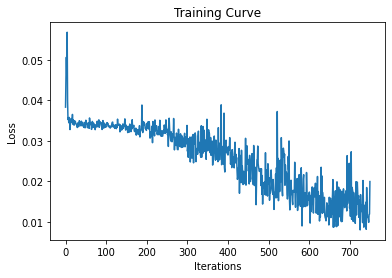

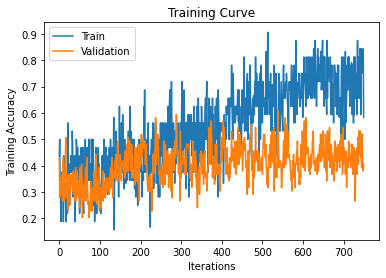

Epoch:  50 Train Accuracy:  0.7288135593220338 Val Accuracy:  0.4177215189873418 Progress:  68.00  % Time Elapsed:  204.13 s 
Epoch 50 Finished.  Time per Epoch:   4.00 s 
Epoch:  51 Train Accuracy:  0.7288135593220338 Val Accuracy:  0.5063291139240507 Progress:  69.33  % Time Elapsed:  208.15 s 
Epoch 51 Finished.  Time per Epoch:   4.00 s 
Epoch:  52 Train Accuracy:  0.739406779661017 Val Accuracy:  0.4050632911392405 Progress:  70.67  % Time Elapsed:  212.15 s 
Epoch 52 Finished.  Time per Epoch:   4.00 s 
Epoch:  53 Train Accuracy:  0.6970338983050848 Val Accuracy:  0.3924050632911392 Progress:  72.00  % Time Elapsed:  216.17 s 
Epoch 53 Finished.  Time per Epoch:   4.00 s 
Epoch:  54 Train Accuracy:  0.7097457627118644 Val Accuracy:  0.3291139240506329 Progress:  73.33  % Time Elapsed:  220.15 s 
Epoch 54 Finished.  Time per Epoch:   4.00 s 
Epoch:  55 Train Accuracy:  0.7351694915254238 Val Accuracy:  0.3037974683544304 Progress:  74.67  % Time Elapsed:  224.18 s 
Epoch 55 Finish

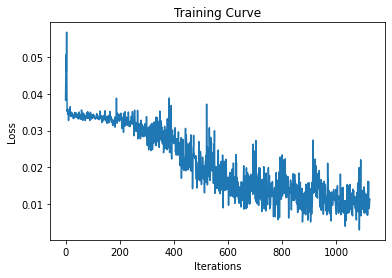

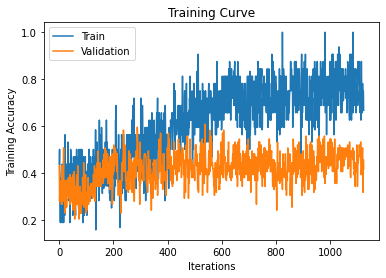

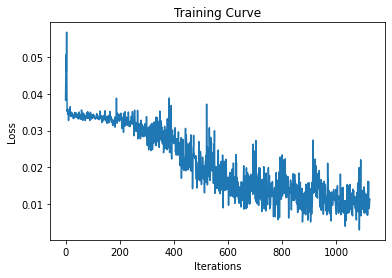

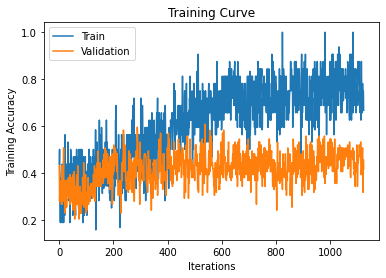

Finished Training
Total time:   301.55 s  Time per Epoch:   4.02 s 


In [215]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 75
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)